In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
pip install neurokit2

     |████████████████████████████████| 1.1 MB 4.5 MB/s 


In [3]:
pip install biosppy==0.6.1

     |████████████████████████████████| 76 kB 2.6 MB/s 


In [4]:
pip install mne

     |████████████████████████████████| 7.4 MB 4.0 MB/s 


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import re
import csv
import scipy.io
import biosppy
import mne
import neurokit2 as nk
import ast
import os
import scipy.io
from sklearn.preprocessing import LabelEncoder
import time
import datetime
from datetime import datetime
import glob
from scipy.stats import zscore, norm
from neurokit2 import eda_phasic
from scipy.stats import linregress
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [6]:
def TimeStamp_Conversion(ts):
  """
  we have a unix epoch time in milliseconds i.e, a string with a length of 13 charcters example:1.5789360034388428E12
  
  parameters:
  -----
  ts = Epoch timesatmp in milliseconds.

  Returns:
  -----
  Std_Unix = standard epoch timestamp in seconds.

  """

  float_Input = float(ts) # converting the string-type(1.5789360034388428E12) Unix Epoch to float-type(1578936003.4388428).

  # float input is divided by 1000 to convert the Unix epoch in milliseconds to seconds 
  Std_Unix = float_Input/1000

  datetime_Input = datetime.fromtimestamp(Std_Unix) 
  # datetime.fromtimestamp converts the unix epoch in seconds to datetime returns example:datetime.datetime(2020, 1, 13, 17, 20, 3, 438843)

  return Std_Unix

In [7]:
def column_formatting(Timestamp_DF):
  """
  Column names of Timestamp annotation excel have column index attached to column name as we only need column name we are parsing column names.

  Parameters:
  -----
  Timestamp_DF = Input the DF after reading the timestamp annotationexcel file to  get list of column names['A1- ECG baseline start','B1- ECG baseline end',.....].

  Returns:
  -----
  Parsed_ColumnNames = list of parsed column names. ['ECG baseline start','ECG baseline end',....]

  """

  Parsed_colnames = ['Subject_ID'] ## Column with Participant ID is not named, so declaring first column as Subject_ID to an empty list

  for index in range(1,len(Timestamp_DF.columns)): ## Looping through the list of timestamp annotation columns list
    column = Timestamp_DF.columns[index][4:].lstrip() ## Drop first 3 indices of each column and strip space(" ") if present as left most
    Parsed_colnames.append(column) ## appending each column name after parsing

  return Parsed_colnames ## returns list fo parsed col names

In [8]:
def Annotation_timestamp(timestamp_path, sheet_name):
  """
  This function is to change the column names of timestamp annotations table and convert timestamps from milliseconds to standart epoch format of seconds.

  Parameters:
  -----
  timestamp_path = path to the directory of file location
  sheet_name =  there are two sheets present in the file, we work on file named D.

  Results:
  -----
  VR_Timestamps_D = Clean dataframe of timestamp annotations table.

  """

  VR_TimeStamps_D = pd.read_excel(Timestamp_path, sheet_name) ## read timestamp annotation file
  Parsed_colnames = column_formatting(VR_TimeStamps_D) ## using the column_formatting function defined earlier parse columns
  VR_TimeStamps_D.columns = Parsed_colnames ## Change colnames of Dataframe using the parsed list of col names
  
  ## As timestamp is in string format and in milli seconds iterating through each column to change the timestamp to standard epoch format.
  for col in VR_TimeStamps_D.columns: 
    ## Using Timestamp_Conversion function and lambda fucntion to map the function to each row of the column.
    if col == 'Subject_ID':
      pass
    else:
      VR_TimeStamps_D[col] = VR_TimeStamps_D[col].map(lambda instance: TimeStamp_Conversion(instance)) 

  return VR_TimeStamps_D

In [9]:
def Shimmers_csv2DF(path,filename):
  """
  This function is to read Shimmer data files and create a dataframe from tidy shimmers csv tables.

  Parameters:
  -----
  path = path to directory of shimmers file folder.

  filename = name of the file to be loaded.

  Results:
  -----
  Dataframe = organized and structured Shimmers Data.

  """

  with open(path + '/' + filename, 'r',) as file: # read the file
    reader = csv.reader(file)

    lists_eachrow = []
    for row in reader:
      lists_eachrow.append(row) # append each row in reader to a list

  del lists_eachrow[0] # del first row of list as it is only about \t delimiter used

  newlists = [] 
  # loop through the list of lists and split columnar values using the delimiter 
  for list_row in lists_eachrow:
    for row in list_row:
      newlists.append(list(row.split('\t')))
  # Extract subjectID from the file name for future use
  filename_parse = filename.replace("_", " ")
  Participant_ID = ast.literal_eval(re.findall(r'\b\d+\b', filename_parse)[0])
  
  # create dataframe from the list of columnar values 
  Dataframe = pd.DataFrame(newlists, columns = newlists[0])
  Dataframe = Dataframe.drop([0,1]) # drop columns 1 and 2 which are column names and units as we already have column names for new dataframe.
  Dataframe.reset_index(drop=True, inplace=True) # reset index

  return Dataframe, Participant_ID

In [10]:
path = '/content/gdrive/My Drive/Food_VR_project/ECG_Processing/ECG_Processing/ECG_DATA'
Timestamp_path = '/content/gdrive/My Drive/Food_VR_project/VR Timestamps for Phase B & D_W&SP20.xlsx'
sheet_name = 'D'

In [11]:
os.chdir(path)
list_csv = glob.glob('*.{}'.format('txt'))
list_csv.extend(glob.glob('*.{}'.format('csv')))

In [12]:
Data = pd.DataFrame()

In [13]:
Dataframe, Participant_ID = Shimmers_csv2DF(path, 'Subj_VR_966_Session1_Shimmer_CB7C_Calibrated_SD.csv')

In [14]:
Dataframe

,Shimmer_CB7C_Timestamp_Unix_CAL,Shimmer_CB7C_Accel_LN_X_CAL,Shimmer_CB7C_Accel_LN_Y_CAL,Shimmer_CB7C_Accel_LN_Z_CAL,Shimmer_CB7C_Accel_WR_X_CAL,Shimmer_CB7C_Accel_WR_Y_CAL,Shimmer_CB7C_Accel_WR_Z_CAL,Shimmer_CB7C_ECG_EMG_Status1_CAL,Shimmer_CB7C_ECG_EMG_Status2_CAL,Shimmer_CB7C_ECG_IBI_LA_RA_CAL,Shimmer_CB7C_ECG_IBI_LL_LA_CAL,Shimmer_CB7C_ECG_IBI_LL_RA_CAL,Shimmer_CB7C_ECG_IBI_Vx_RL_CAL,Shimmer_CB7C_ECG_LA-RA_24BIT_CAL,Shimmer_CB7C_ECG_LL-LA_24BIT_CAL,Shimmer_CB7C_ECG_LL-RA_24BIT_CAL,Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL,Shimmer_CB7C_ECGtoHR_LA_RA_CAL,Shimmer_CB7C_ECGtoHR_LL_LA_CAL,Shimmer_CB7C_ECGtoHR_LL_RA_CAL,Shimmer_CB7C_ECGtoHR_Vx_RL_CAL,Shimmer_CB7C_Gyro_X_CAL,Shimmer_CB7C_Gyro_Y_CAL,Shimmer_CB7C_Gyro_Z_CAL,Shimmer_CB7C_Mag_X_CAL,Shimmer_CB7C_Mag_Y_CAL,Shimmer_CB7C_Mag_Z_CAL,
0,1.583774300110138E12,1.8369565217391304,10.728260869565217,5.293478260869565,-0.7205266307600239,8.933572710951525,3.595451825254339,128.0,128.0,-1.0,-1.0,-1.0,-1.0,2.022578957388277,12.136122838988644,14.15870179637692,-1.3915868272288834,-1.0,-1.0,-1.0,-1.0,-0.5190839694656488,3.16030534351145,-2.3053435114503817,-0.10044977511244378,0.0239880059970015,0.2893553223388306,
1,1.5837743001199036E12,1.826086956521739,10.717391304347826,5.315217391304348,-0.7253141831238779,8.93836026331538,3.6217833632555356,128.0,128.0,-1.0,-1.0,-1.0,-1.0,2.0326038637881116,12.138358609480694,14.170962473268805,-1.3952650302964487,-1.0,-1.0,-1.0,-1.0,-0.6106870229007634,3.2213740458015265,-1.8778625954198473,-0.10344827586206896,0.022488755622188904,0.2773613193403298,
2,1.5837743001218567E12,1.8369565217391304,10.717391304347826,5.282608695652174,-0.7516457211250748,8.981448234590065,3.6122082585278275,128.0,128.0,-1.0,-1.0,-1.0,-1.0,2.0441433243922384,12.136267082246196,14.180410406638433,-1.4041359906358708,-1.0,-1.0,-1.0,-1.0,-0.6717557251908397,3.5267175572519083,-2.045801526717557,-0.10344827586206896,0.022488755622188904,0.2773613193403298,
3,1.5837743001238098E12,1.8369565217391304,10.739130434782608,5.282608695652174,-0.7253141831238779,8.971873129862358,3.6193895870736084,128.0,128.0,-1.0,-1.0,-1.0,-1.0,2.055682784996365,12.14167620440438,14.197358989400744,-1.3904328811684705,-1.0,-1.0,-1.0,-1.0,-0.6106870229007634,3.3435114503816794,-2.091603053435114,-0.10344827586206896,0.022488755622188904,0.2773613193403298,
4,1.583774300125763E12,1.826086956521739,10.739130434782608,5.293478260869565,-0.7229204069419509,8.96229802513465,3.557151406343507,128.0,128.0,-1.0,-1.0,-1.0,-1.0,2.062173731586186,12.138647095995797,14.200820827581982,-1.4021165850301487,-1.0,-1.0,-1.0,-1.0,-0.42748091603053434,3.3740458015267176,-1.9541984732824427,-0.10344827586206896,0.022488755622188904,0.2773613193403298,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054650,1.5837763755886536E12,3.108695652173913,10.934782608695652,4.641304347826087,0.6271693596648713,9.108318372232196,2.9347695990424896,128.0,128.0,-1.0,-1.0,-1.0,-1.0,-0.026685002647042592,-2.8587571214147953,-2.885442124061838,12.485912738551228,89.04347826086956,89.04347826086956,89.04347826086956,89.04347826086956,-1.5381977576335877,-1.5133587786259541,0.12115338740458015,0.17541229385307347,-0.06146926536731634,0.4422788605697151,
1054651,1.5837763755906067E12,3.1304347826086953,10.934782608695652,4.6521739130434785,0.6152004787552364,9.11310592459605,2.963494913225613,128.0,128.0,-1.0,-1.0,-1.0,-1.0,-0.028992894767867896,-2.8655365545197196,-2.8945294492875875,12.476681170067927,89.04347826086956,89.04347826086956,89.04347826086956,89.04347826086956,-1.2328542461832062,-1.4064885496183206,-0.16892294847328243,0.17541229385307347,-0.06146926536731634,0.4422788605697151,
1054652,1.5837763755925598E12,3.119565217391304,10.934782608695652,4.641304347826087,0.6726511071214841,9.115499700777978,2.9204069419509273,128.0,128.0,-1.0,-1.0,-1.0,-1.0,-0.02553105658662994,-2.859550459331329,-2.885081515917959,12.506828010896209,89.04347826086956,89.043478260869

In [16]:
Participant_ID

966

In [50]:
Dataframe_ecg_signals = Dataframe[['Shimmer_CB7C_ECG_LA-RA_24BIT_CAL', 'Shimmer_CB7C_ECG_LL-LA_24BIT_CAL', 'Shimmer_CB7C_ECG_LL-RA_24BIT_CAL', 'Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL']]

Dataframe_ecg_signals['Shimmer_CB7C_ECG_LA-RA_24BIT_CAL'] = pd.to_numeric(Dataframe_ecg_signals['Shimmer_CB7C_ECG_LL-LA_24BIT_CAL'], errors='coerce')

Dataframe_ecg_signals['Shimmer_CB7C_ECG_LL-RA_24BIT_CAL'] = pd.to_numeric(Dataframe_ecg_signals['Shimmer_CB7C_ECG_LL-RA_24BIT_CAL'], errors='coerce')

Dataframe_ecg_signals['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'] = pd.to_numeric(Dataframe_ecg_signals['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'], errors='coerce')

Dataframe_ecg_signals['Shimmer_CB7C_ECG_LL-LA_24BIT_CAL'] = pd.to_numeric(Dataframe_ecg_signals['Shimmer_CB7C_ECG_LL-LA_24BIT_CAL'], errors='coerce')

Dataframe_ecg_signals

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,Shimmer_CB7C_ECG_LA-RA_24BIT_CAL,Shimmer_CB7C_ECG_LL-LA_24BIT_CAL,Shimmer_CB7C_ECG_LL-RA_24BIT_CAL,Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL
0,12.136123,12.136123,14.158702,-1.391587
1,12.138359,12.138359,14.170962,-1.395265
2,12.136267,12.136267,14.180410,-1.404136
3,12.141676,12.141676,14.197359,-1.390433
4,12.138647,12.138647,14.200821,-1.402117
...,...,...,...,...
1054650,-2.858757,-2.858757,-2.885442,12.485913
1054651,-2.865537,-2.865537,-2.894529,12.476681
1054652,-2.859550,-2.859550,-2.885082,12.506828
1054653,-2.850103,-2.850103,-2.878374,12.489014


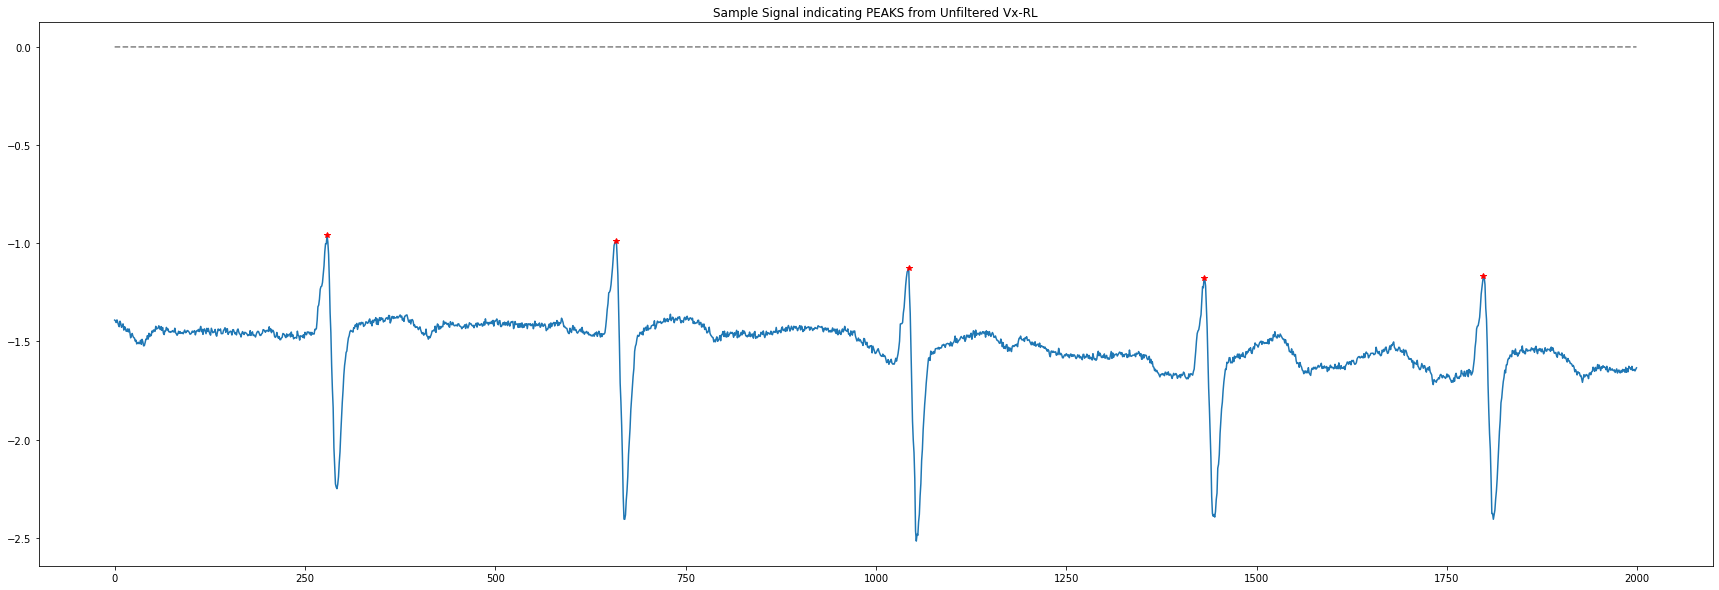

In [51]:
%matplotlib inline
from scipy.signal import find_peaks
peaks_1, _ = find_peaks(Dataframe_ecg_signals['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'][:2000], distance=300)
diff_peaks_1 = np.diff(peaks_1)
plt.figure(figsize=(30, 10))
plt.plot(Dataframe_ecg_signals['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'][:2000])
plt.plot(peaks_1, Dataframe_ecg_signals['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'][peaks_1], "*", color = 'red')
plt.plot(np.zeros_like(Dataframe_ecg_signals['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'][:2000]), "--", color="gray")
plt.title('Sample Signal indicating PEAKS from Unfiltered Vx-RL')
plt.show()



In [52]:
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
import matplotlib.pyplot as plt
## A high pass filter allows frequencies higher than a cut-off value
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False, output='ba')
    return b, a
## A low pass filter allows frequencies lower than a cut-off value
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False, output='ba')
    return b, a
def notch_filter(cutoff, q):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

def highpass(data, fs, order=5):
    b,a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b,a,data)
    return x

def lowpass(data, fs, order =5):
    b,a = butter_lowpass(cutoff_low, fs, order=order)
    y = lfilter(b,a,data)
    return y

def notch(data, powerline, q):
    b,a = notch_filter(powerline,q)
    z = lfilter(b,a,data)
    return z

def final_filter(data, fs, order=5):
    b, a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b, a, data)
    d, c = butter_lowpass(cutoff_low, fs, order = order)
    y = lfilter(d, c, x)
    f, e = notch_filter(powerline, 30)
    z = lfilter(f, e, y)     
    return z


fs = 128
cutoff_high = 0.5
cutoff_low = 2
powerline = 50
order = 5



<Figure size 432x288 with 0 Axes>

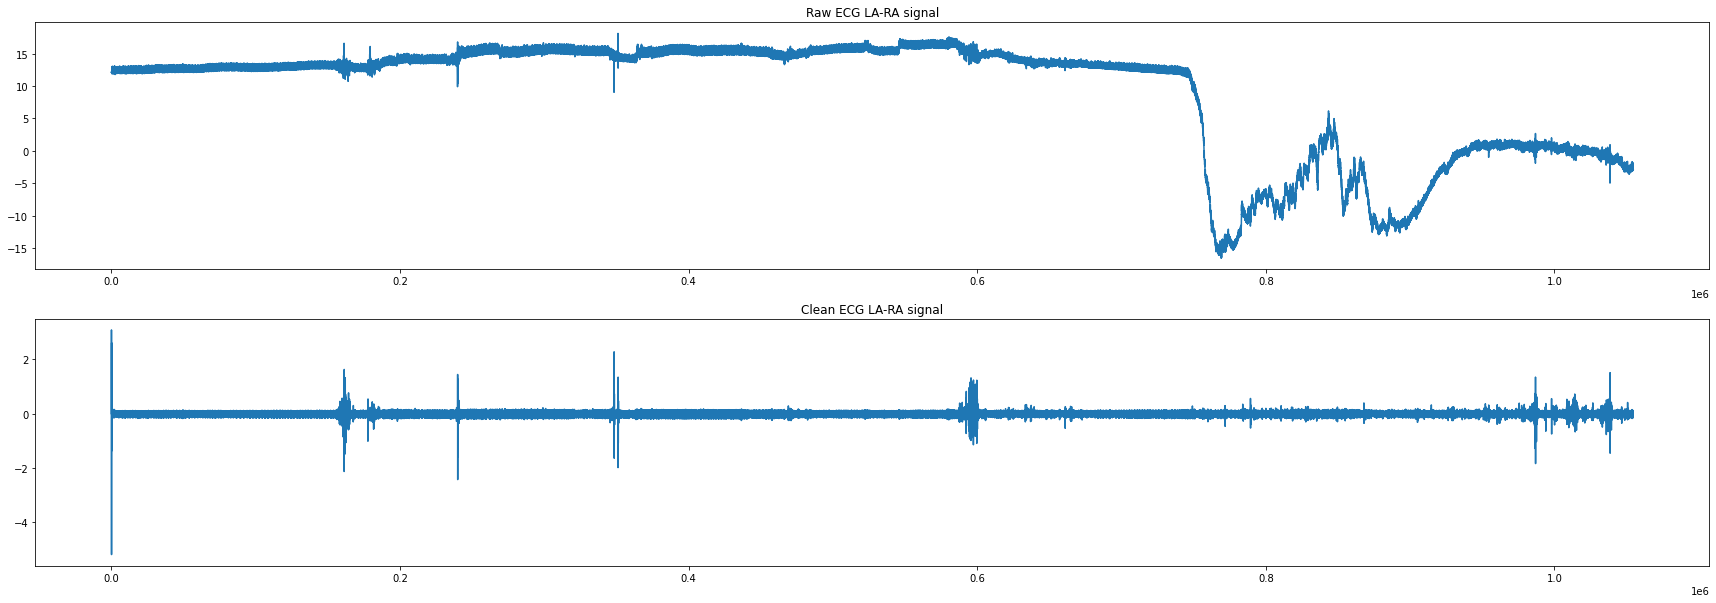

In [53]:
plt.figure(1)

plt.figure(figsize=(30, 10))

ax1 = plt.subplot(211)
plt.plot(Dataframe_ecg_signals['Shimmer_CB7C_ECG_LA-RA_24BIT_CAL'])
ax1.set_title("Raw ECG LA-RA signal")

filter_signal = final_filter(Dataframe_ecg_signals['Shimmer_CB7C_ECG_LA-RA_24BIT_CAL'], fs, order)
ax2 = plt.subplot(212)
plt.plot(filter_signal)
ax2.set_title("Clean ECG LA-RA signal")
plt.show()

<Figure size 432x288 with 0 Axes>

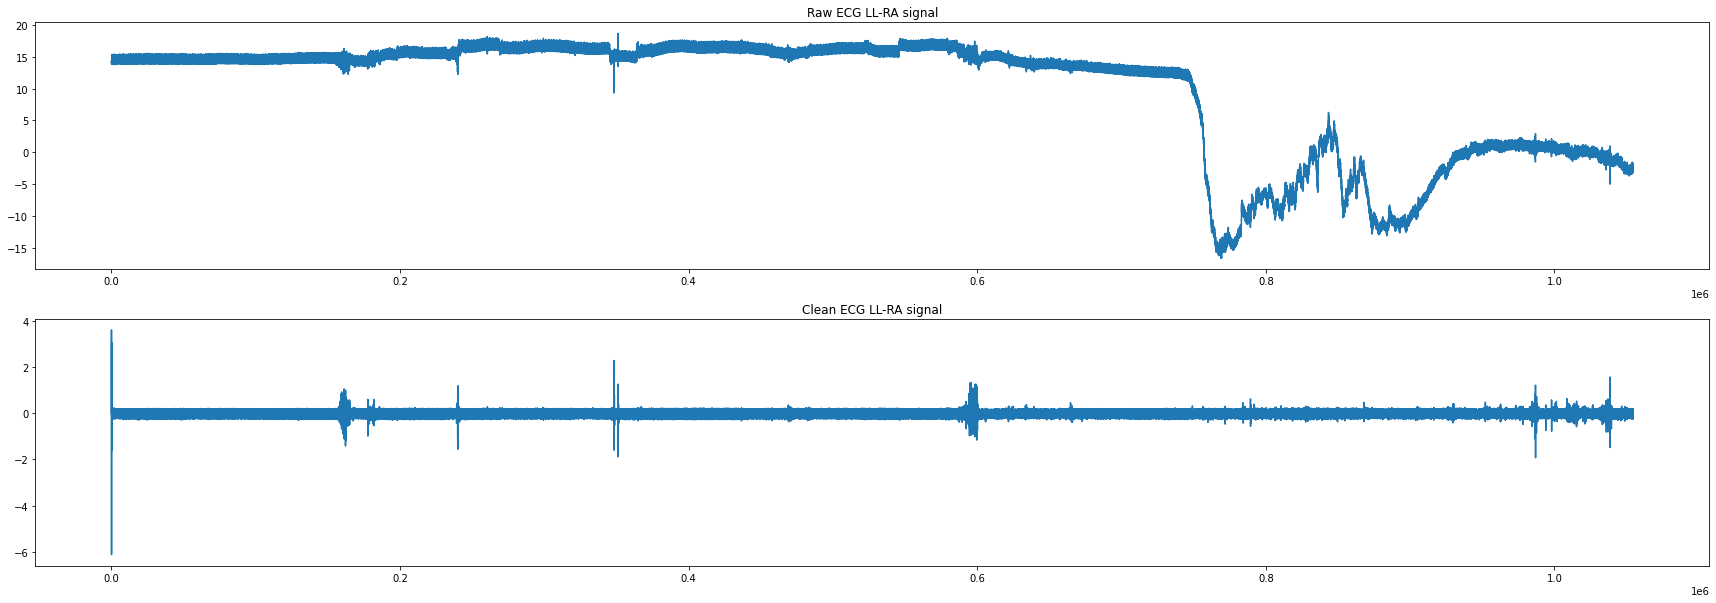

In [54]:
plt.figure(1)

plt.figure(figsize=(30, 10))

ax1 = plt.subplot(211)
plt.plot(Dataframe_ecg_signals['Shimmer_CB7C_ECG_LL-RA_24BIT_CAL'])
ax1.set_title("Raw ECG LL-RA signal")

filter_signal = final_filter(Dataframe_ecg_signals['Shimmer_CB7C_ECG_LL-RA_24BIT_CAL'], fs, order)
ax2 = plt.subplot(212)
plt.plot(filter_signal)
ax2.set_title("Clean ECG LL-RA signal")
plt.show()

<Figure size 432x288 with 0 Axes>

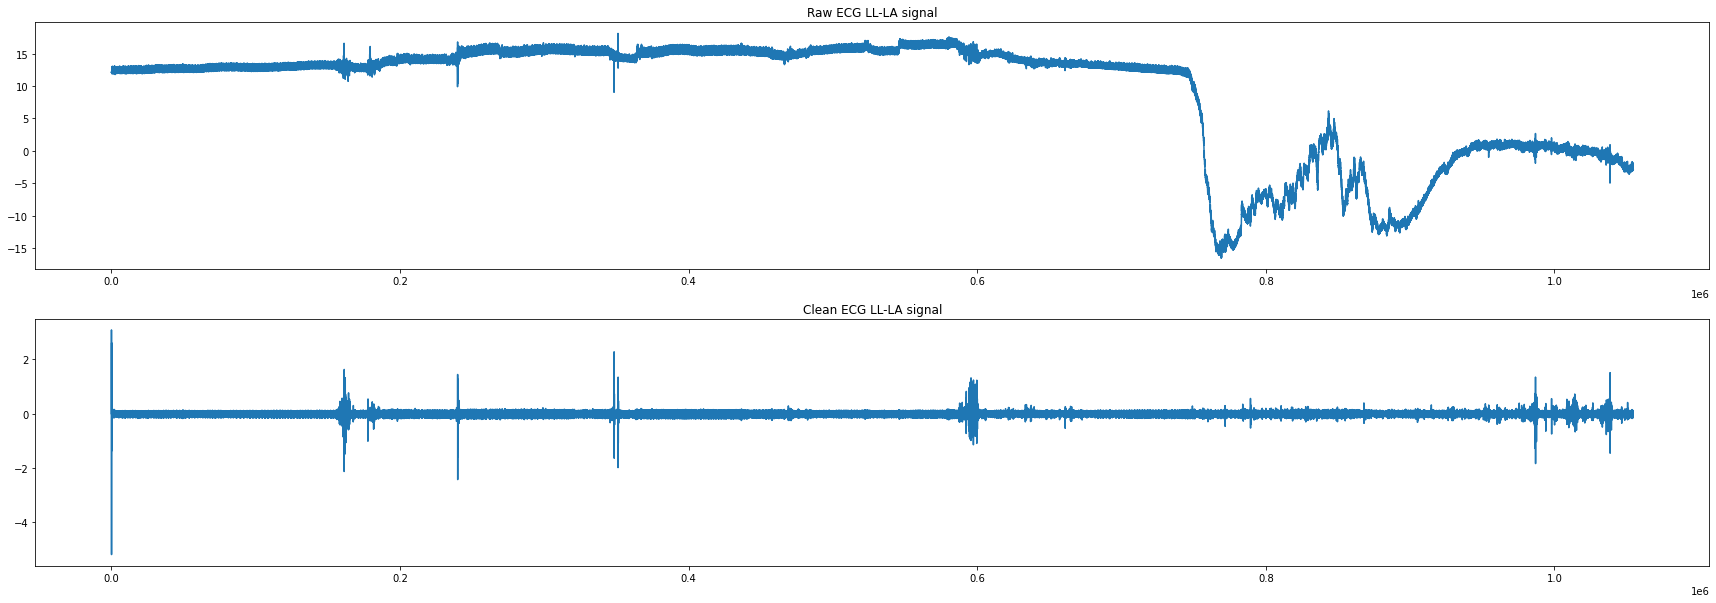

In [55]:
plt.figure(1)

plt.figure(figsize=(30, 10))

ax1 = plt.subplot(211)
plt.plot(Dataframe_ecg_signals['Shimmer_CB7C_ECG_LL-LA_24BIT_CAL'])
ax1.set_title("Raw ECG LL-LA signal")

filter_signal = final_filter(Dataframe_ecg_signals['Shimmer_CB7C_ECG_LL-LA_24BIT_CAL'], fs, order)
ax2 = plt.subplot(212)
plt.plot(filter_signal)
ax2.set_title("Clean ECG LL-LA signal")
plt.show()

<Figure size 432x288 with 0 Axes>

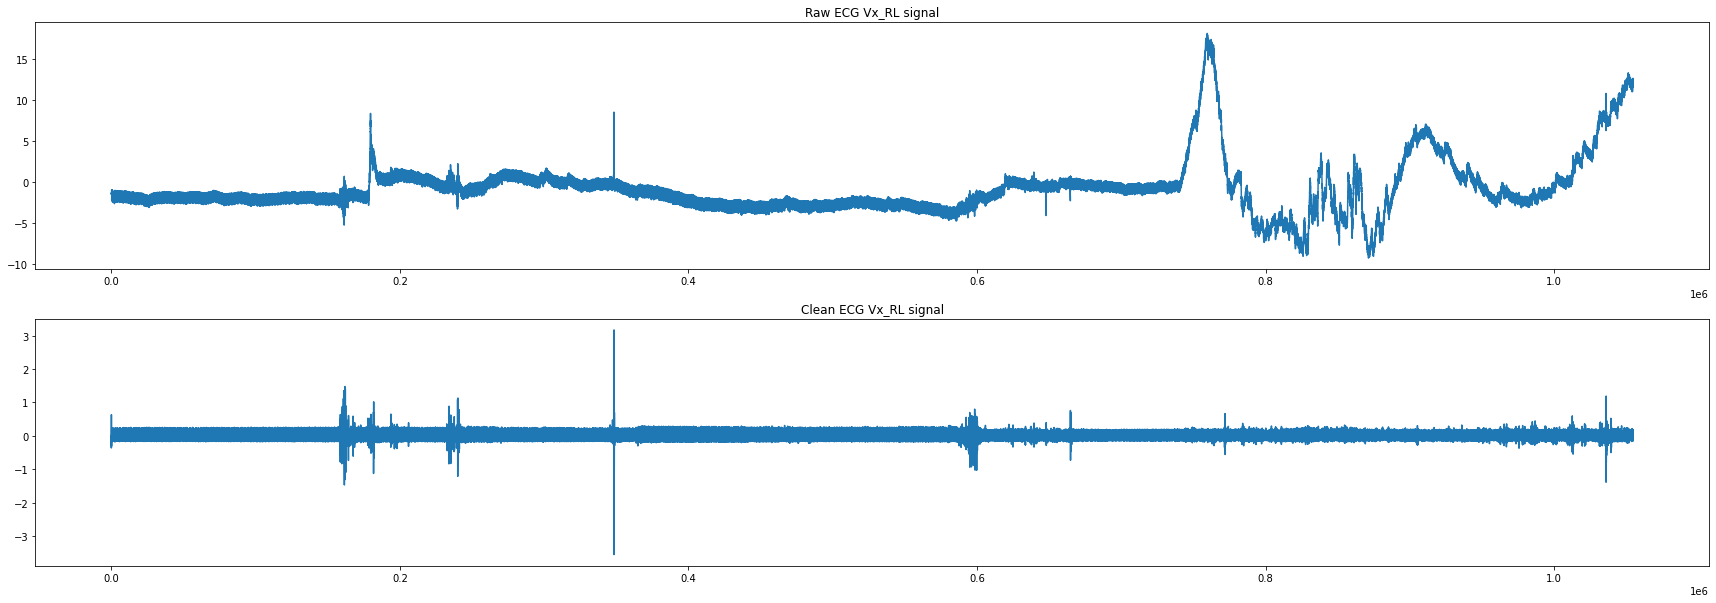

In [56]:
plt.figure(1)

plt.figure(figsize=(30, 10))

ax1 = plt.subplot(211)
plt.plot(Dataframe_ecg_signals['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'])
ax1.set_title("Raw ECG Vx_RL signal")

filter_signal = final_filter(Dataframe_ecg_signals['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'], fs, order)
ax2 = plt.subplot(212)
plt.plot(filter_signal)
ax2.set_title("Clean ECG Vx_RL signal")
plt.show()

In [57]:
Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'] = Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'].map(lambda instance: TimeStamp_Conversion(instance))

In [58]:
Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL']

0          1.583774e+06
1          1.583774e+06
2          1.583774e+06
3          1.583774e+06
4          1.583774e+06
               ...     
1054650    1.583776e+06
1054651    1.583776e+06
1054652    1.583776e+06
1054653    1.583776e+06
1054654    1.583776e+06
Name: Shimmer_CB7C_Timestamp_Unix_CAL, Length: 1054655, dtype: float64

In [29]:
for index in range(0,4):
  # columns = ['Shimmer_CB7C_ECG_IBI_LA_RA_CAL',
  #             'Shimmer_CB7C_ECG_IBI_LL_LA_CAL', 
  #             'Shimmer_CB7C_ECG_IBI_LL_RA_CAL',
  #             'Shimmer_CB7C_ECG_IBI_Vx_RL_CAL',
  #             'Shimmer_CB7C_ECG_LA-RA_24BIT_CAL']
    columns = ['Shimmer_CB7C_ECG_LA-RA_24BIT_CAL', 'Shimmer_CB7C_ECG_LL-LA_24BIT_CAL', 'Shimmer_CB7C_ECG_LL-RA_24BIT_CAL', 'Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL']

Dataframe[columns[index]] = Dataframe[columns[index]].map(lambda ind : ast.literal_eval(ind))

In [59]:
Dataframe_ecg_signals = Dataframe[['Shimmer_CB7C_ECG_LA-RA_24BIT_CAL', 'Shimmer_CB7C_ECG_LL-LA_24BIT_CAL', 'Shimmer_CB7C_ECG_LL-RA_24BIT_CAL', 'Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL']]
Dataframe_ecg_signals

,Shimmer_CB7C_ECG_LA-RA_24BIT_CAL,Shimmer_CB7C_ECG_LL-LA_24BIT_CAL,Shimmer_CB7C_ECG_LL-RA_24BIT_CAL,Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL
0,2.022578957388277,12.136122838988644,14.15870179637692,-1.3915868272288834
1,2.0326038637881116,12.138358609480694,14.170962473268805,-1.3952650302964487
2,2.0441433243922384,12.136267082246196,14.180410406638433,-1.4041359906358708
3,2.055682784996365,12.14167620440438,14.197358989400744,-1.3904328811684705
4,2.062173731586186,12.138647095995797,14.200820827581982,-1.4021165850301487
...,...,...,...,...
1054650,-0.026685002647042592,-2.8587571214147953,-2.885442124061838,12.485912738551228
1054651,-0.028992894767867896,-2.8655365545197196,-2.8945294492875875,12.476681170067927
1054652,-0.02553105658662994,-2.859550459331329,-2.885081515917959,12.506828010896209
1054653,-0.028271678480109988,-2.8501025259617006,-2.8783742044418106,12.489013968588587


In [60]:
Dataframe_ecg_signals['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'] = pd.to_numeric(Dataframe_ecg_signals['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:
picked_ECG_signal = Dataframe_ecg_signals['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL']
picked_ECG_signal

0          -1.391587
1          -1.395265
2          -1.404136
3          -1.390433
4          -1.402117
             ...    
1054650    12.485913
1054651    12.476681
1054652    12.506828
1054653    12.489014
1054654    12.478556
Name: Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL, Length: 1054655, dtype: float64

In [62]:
filtered_signal = final_filter(Dataframe_ecg_signals['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'], fs, order)
filtered_signal

array([-3.13627632e-07, -3.34526041e-06, -1.78710784e-05, ...,
        4.11709535e-02,  3.11874219e-02,  2.13831846e-02])

In [63]:
%matplotlib inline
from scipy.signal import find_peaks
peaks, _ = find_peaks(filtered_signal, distance=300)

peaks

array([     85,     739,    1121, ..., 1053948, 1054290, 1054633])

In [64]:
len(peaks)

2805

In [65]:
# R-R intervals
rr = np.diff(peaks)
rr, len(rr)

(array([654, 382, 392, ..., 339, 342, 343]), 2804)

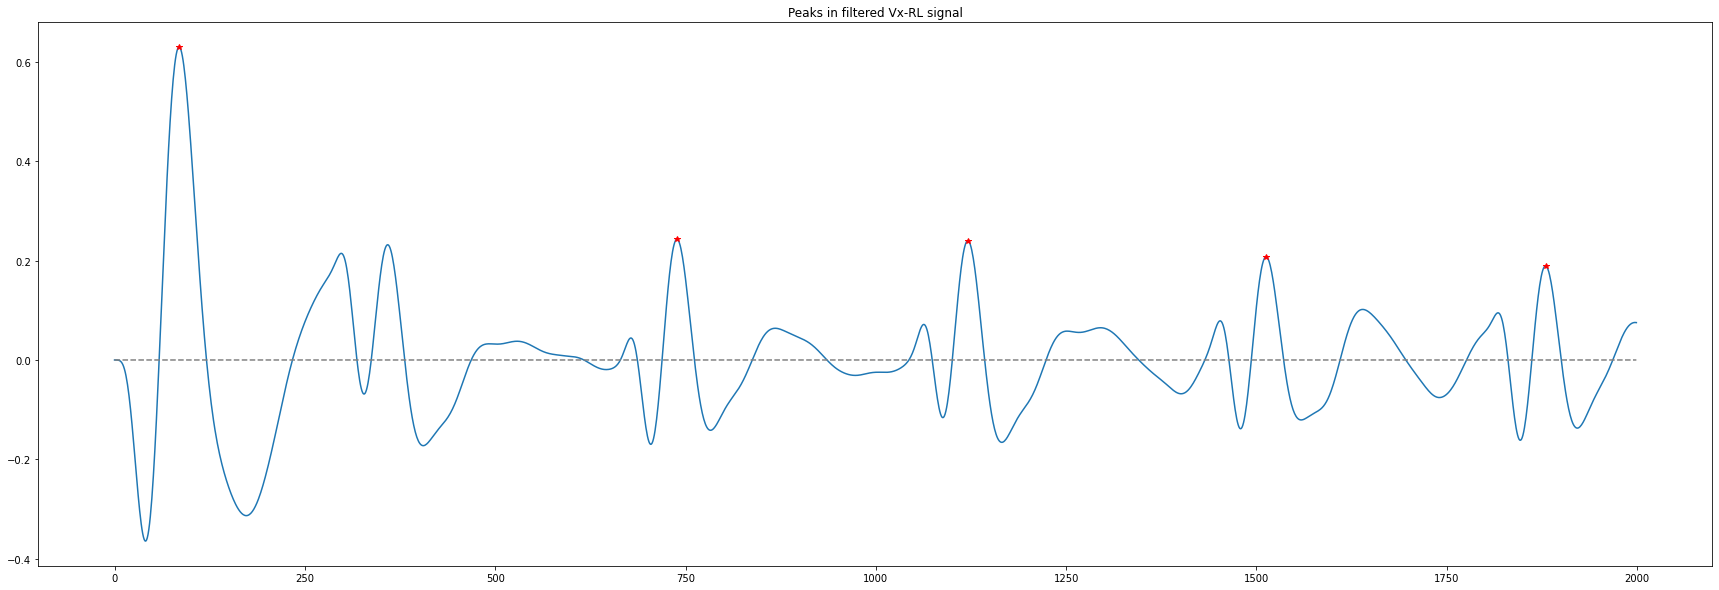

In [67]:

#creating a subplot for the filtered signal 

%matplotlib inline
from scipy.signal import find_peaks
peaks_2, _ = find_peaks(filtered_signal[:2000], distance=300)
diff_peaks_2 = np.diff(peaks_2)
plt.figure(figsize=(30, 10))
plt.plot(filtered_signal[:2000])
plt.plot(peaks_2, filtered_signal[peaks_2], "*", color = 'red')
plt.plot(np.zeros_like(filtered_signal[:2000]), "--", color="gray")
plt.title('Peaks in filtered Vx-RL signal')
plt.show()

In [36]:
#matching the peaks indices with the original ECG signal

ecg_peaks = filtered_signal[peaks]
ecg_peaks

array([0.63009782, 0.24296463, 0.23998878, ..., 0.21154387, 0.19385128,
       0.17435882])

In [37]:
Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'] = pd.to_numeric(Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'])


In [39]:
ecg_peaks_time = Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'][peaks]
ecg_peaks_time = np.array(ecg_peaks_time)
ecg_peaks_time, len(ecg_peaks_time)

(array([1.58377430e+09, 1.58377430e+09, 1.58377430e+09, ...,
        1.58377637e+09, 1.58377637e+09, 1.58377638e+09]), 2805)

In [84]:
#time domain Features
def timedomain(rr):
    results = {}

    hr = (60000)/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = (60000)/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

print("Time domain metrics - automatically corrected RR-intervals:")
for k, v in timedomain(rr).items():
    print("- %s: %.2f" % (k, v))

Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 376.09
- STD RR/SDNN (ms): 45.10
- Mean HR (Kubios' style) (beats/min): 159.54
- Mean HR (beats/min): 161.46
- STD HR (beats/min): 16.52
- Min HR (beats/min): 90.91
- Max HR (beats/min): 200.00
- RMSSD (ms): 47.65
- NNxx: 206.00
- pNNxx (%): 7.35


In [83]:

# frequency Domain Features

from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

x = np.cumsum(rr) / 1000
f = interp1d(x, rr, kind='cubic')

fs = 4.0
steps = 1 / fs

# sample from interpolation function
xx = np.arange(1, np.max(x), steps)
rr_interpolated = f(xx)

def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain(rr_interpolated)

for k, v in results.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 110.92
- Power LF (ms2): 322.13
- Power HF (ms2): 533.78
- Power Total (ms2): 966.83
- LF/HF: 0.60
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.06
- Peak HF (Hz): 0.17
- Fraction LF (nu): 37.64
- Fraction HF (nu): 62.36


In [56]:
ibi_df = pd.DataFrame()

ibi_first_timestamp = ecg_peaks_time[0]
ibi_df[0] = np.diff(ecg_peaks_time)
ibi_df[0][0] = ibi_first_timestamp

ibi_df['ibi'] =  np.diff(ecg_peaks)

ibi_df


,0,ibi
0,1.583774e+12,-0.387133
1,7.500000e+02,-0.002976
2,7.656250e+02,-0.032394
3,7.167969e+02,-0.018444
4,7.167969e+02,0.006422
...,...,...
2799,7.519531e+02,0.015090
2800,6.875000e+02,0.001666
2801,6.640625e+02,0.022722
2802,6.738281e+02,-0.017693


In [40]:
timestamp = np.array(ecg_peaks_time)

'''
--- As the neurokit function we are using to extract HRV features will only give one row as output when a signal is passed as input
--- I am using sliding window technique to extract features for every 60 data points(window length) and an overlap of 30 data points
--- we can expect average of one R peak for every second(i.e, 128Hz), as we are using 60 data points in each window means we are windowing for every 60 seconds with a 30 second overlap 
'''
start_window=0
overlap=30
window_length=60 
end_window = window_length
ecg = rr

data = pd.DataFrame() # empty dataframe to append HRV features for each window
while (start_window + overlap) <= len(ecg): # loop conditon to carry out windowing and calculate features till the end 
  
  # creating start, mean and end timestamps helps to  make sure that each window completely falls in annotation period
  Start_timestamp = timestamp[start_window]
  Mean_timestamp = np.mean(timestamp[start_window:end_window])
  try:
    end_timestamp = timestamp[end_window]
  except IndexError: 
    # index of last window might exceed the last timestamp of our data, if this happens it will use last timestamp of data as end timsatmp of last window
    end_timestamp = timestamp[-1]

  ecg_window = ecg[start_window:end_window] # getting ecg samples for each winodw

  hrv = nk.hrv_time(ecg_window, sampling_rate=128, show=False) # This takes ecg signal input for each window and gives each feature output as data frame column  
  # if we have freq domain of input data you can use hrv_freq to compute hrv features, similarly with non linear
  
  # appending start, mean and end timestamp which helps in labelling event periods to each efature column
  hrv['Start_timestamp'] = Start_timestamp 
  hrv['Mean_timestamp'] = Mean_timestamp
  hrv['end_timestamp'] = end_timestamp
  hrv['subject_ID'] = Participant_ID
  
  # append HRV features from each window to empty datafrme
  data = data.append(hrv)

  # increasing window length
  start_window += overlap
  end_window += overlap

# data = data.dropna() # drop null values if any, as few rows consists of nulls values and infinity values while computing features
Data = Data.append(data)

ValueError: ignored

In [53]:
hrv = nk.hrv_time(ecg_peaks, sampling_rate=128, show=False)

ValueError: ignored

In [130]:
ecg_peaks

279        -0.960083
659        -0.986408
1043       -1.125963
1431       -1.178756
1798       -1.165413
             ...    
1053178    12.458939
1053528    12.390135
1053867    12.324360
1054208    12.237237
1054551    12.616309
Name: Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL, Length: 2841, dtype: float64